In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import time

In [2]:
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ep-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/cg-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/rodinia/rodinia_3.1/openmp/cfd/cfd-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/Quicksilver/omp/qs-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/XSBench/omp/xsbench-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/miniFE/omp/minife-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/CoMD/omp/comd-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/rodinia/rodinia_3.1/openmp/heartwall/heartwall-data'
#trialsDir = '/g/g15/bolet1/workspace/lulesh-region-fix-correct/LULESH/build/lulesh-data/'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/lu-data'
trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data'


problemSize = 'medprob'
pava = 'VA'
trialsToUse=[0,1]

In [3]:
%%time
# let's open all the CSV files in the given directory
csvs = []
for trial in trialsToUse:
    csvs = csvs + list(glob.glob(trialsDir+'/'+'*-'+problemSize+'*-trial'+str(trial)+'*-'+pava+'-traces/*.csv'))
    
print('Reading CSVs:\n', '\n'.join([os.path.basename(x) for x in csvs]))

df = pd.DataFrame()
for idx, csv in enumerate(csvs):
    print(csv, 'reading csv', idx+1, 'of', len(csvs), end='')
    starttime = time.time()
    rawdf = pd.read_csv(csv, sep=' ')
    df = df.append(rawdf)
    print(' -- Read in', time.time()-starttime, 'seconds')

Reading CSVs:
 trace-Static,policy=0-region-ft.c.apollo.region.l199-rank-0.csv
trace-Static,policy=0-region-ft.c.apollo.region.l376-rank-0.csv
trace-Static,policy=0-region-ft.c.apollo.region.l263-rank-0.csv
trace-Static,policy=0-region-ft.c.apollo.region.l447-rank-0.csv
trace-Static,policy=0-region-ft.c.apollo.region.l480-rank-0.csv
trace-Static,policy=0-region-ft.c.apollo.region.l513-rank-0.csv
trace-Static,policy=0-region-ft.c.apollo.region.l223-rank-0.csv
trace-Static,policy=0-region-ft.c.apollo.region.l676-rank-0.csv
trace-Static,policy=1-region-ft.c.apollo.region.l199-rank-0.csv
trace-Static,policy=1-region-ft.c.apollo.region.l376-rank-0.csv
trace-Static,policy=1-region-ft.c.apollo.region.l263-rank-0.csv
trace-Static,policy=1-region-ft.c.apollo.region.l447-rank-0.csv
trace-Static,policy=1-region-ft.c.apollo.region.l480-rank-0.csv
trace-Static,policy=1-region-ft.c.apollo.region.l513-rank-0.csv
trace-Static,policy=1-region-ft.c.apollo.region.l223-rank-0.csv
trace-Static,policy=1-reg

In [4]:
%%time

# let's only keep a few columns
df = df[['region', 'globalidx', 'policy', 'xtime']]
df = df.reset_index(drop=True)

# average out the xtimes for each trial
if len(trialsToUse) > 1:
    df = df.groupby(['region', 'globalidx', 'policy'])['xtime'].mean().reset_index().sort_values(by=['globalidx'])   

CPU times: user 12.2 ms, sys: 2.87 ms, total: 15.1 ms
Wall time: 13.8 ms


In [5]:
%%time
# sanity check the shape
print(df.shape)
print(df.columns)

# if we're working with lulesh data, let's plot the beginning data
#luleshdf = df.loc[(df['globalidx'] <= 15000) & (df['globalidx'] >= 10000)]

(333, 4)
Index(['region', 'globalidx', 'policy', 'xtime'], dtype='object')
CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 884 µs


In [6]:
def plotAllPolicies(df, policiesToPlot=[0,1,2]):
    df = df.loc[[ (x in policiesToPlot) for x in df['policy']]]
    
    grouped = df.groupby(['region', 'globalidx'])
    maxs = df.loc[grouped['xtime'].idxmax()]
    toplot = maxs.sort_values(by=['globalidx']).reset_index(drop=True)
    #toplot = maxs.copy()

    # We will also count the number of unique regions, discrtize, and map them to integers
    regions = list(toplot['region'].unique())
    num_regions = len(regions)

    region_map = dict(zip(regions, range(num_regions)))

    # set the starting point of all the groups of policies
    toplot['x_start'] = toplot['xtime'].cumsum().shift(fill_value=0)

    toplot.drop('policy', axis=1, inplace=True)
    toplot.drop('xtime', axis=1, inplace=True)
    
    #now let's add the endpoint columns
    for pol in policiesToPlot:
        toplot['x_end'+str(pol)] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == pol].sort_values(by=['globalidx'])['xtime'].to_numpy()
    
    #toplot['x_end0'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 0].sort_values(by=['globalidx'])['xtime'].to_numpy()
    #toplot['x_end1'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 1].sort_values(by=['globalidx'])['xtime'].to_numpy()
    #toplot['x_end2'] = toplot['x_start'].to_numpy() + df.loc[df['policy'] == 2].sort_values(by=['globalidx'])['xtime'].to_numpy()
    
    # make the y-axis values for each datapoint
    toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)
    
    # Now that we have the necessary columns, let's plot ALL the policies
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18, 10)
    fig1.set_dpi(500)

    offset=0.1
    
    polData = [
               ('x_end0', offset, 'red', 'policy0'),
               ('x_end1', 0, 'green', 'policy1'),
               ('x_end2', -offset, 'blue', 'policy2')
              ]

    for index, row in toplot.iterrows():
        for pol in policiesToPlot:
            ax1.plot([row.x_start, row[polData[pol][0]]], [row.y+polData[pol][1], row.y+polData[pol][1]], color=polData[pol][2],   label=polData[pol][3], marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end0], [row.y+offset, row.y+offset], color='red',   label='policy0', marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end1], [row.y,        row.y       ], color='green', label='policy1', marker='o', markersize=4)
        #ax1.plot([row.x_start, row.x_end2], [row.y-offset, row.y-offset], color='blue',  label='policy2', marker='o', markersize=4)
        if (index % 1000) == 0:
            print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')

    print(region_map.keys())

    ax1.set_title(trialsDir+' -- '+problemSize+' averaged over static '+pava+' trials:'+str(trialsToUse))
    #ax1.set_yticklabels(regions)
    ax1.set_yticks(list(region_map.values()))
    ax1.set_yticklabels(list(region_map.keys()))
    ax1.set_xlabel('Execution Time (seconds)')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    plt.show()
    return

def plotOptimalPolicy(df, policiesToPlot=[0,1,2]):
    df = df.loc[[ (x in policiesToPlot) for x in df['policy']]]
    
    grouped = df.groupby(['region', 'globalidx'])
    mins = df.loc[grouped['xtime'].idxmin()]
    toplot = mins.sort_values(by=['globalidx']).reset_index(drop=True)
    #toplot = mins.copy()
    
    # We will also count the number of unique regions, discrtize, and map them to integers
    regions = list(toplot['region'].unique())
    num_regions = len(regions)

    region_map = dict(zip(regions, range(num_regions)))

    # set the starting point of all the groups of policies
    toplot['x_end'] = toplot['xtime'].cumsum()
    toplot['x_start'] = toplot['x_end'].shift(fill_value=0)

    #toplot.drop('policy', axis=1, inplace=True)
    toplot.drop('xtime', axis=1, inplace=True)
    
    # make the y-axis values for each datapoint
    toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)
    
    policyColors = ['red', 'green', 'blue']
    
    # Now that we have the necessary columns, let's plot ALL the policies
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18, 10)
    fig1.set_dpi(500)

    for index, row in toplot.iterrows():
        ax1.plot([row.x_start, row.x_end], [row.y, row.y], color=policyColors[row.policy],   label='policy'+str(row.policy), marker='o', markersize=4)
        if (index % 1000) == 0:
            print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')

    print(region_map.keys())

    ax1.set_title(trialsDir+' -- '+problemSize+' averaged over static '+pava+' trials:'+str(trialsToUse))
    #ax1.set_yticklabels(regions)
    ax1.set_yticks(list(region_map.values()))
    ax1.set_yticklabels(list(region_map.keys()))
    ax1.set_xlabel('Execution Time (seconds)')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    plt.show()
    
    

    return
    

current index:  0 ( 0.9009009009009009 )
dict_keys(['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676'])


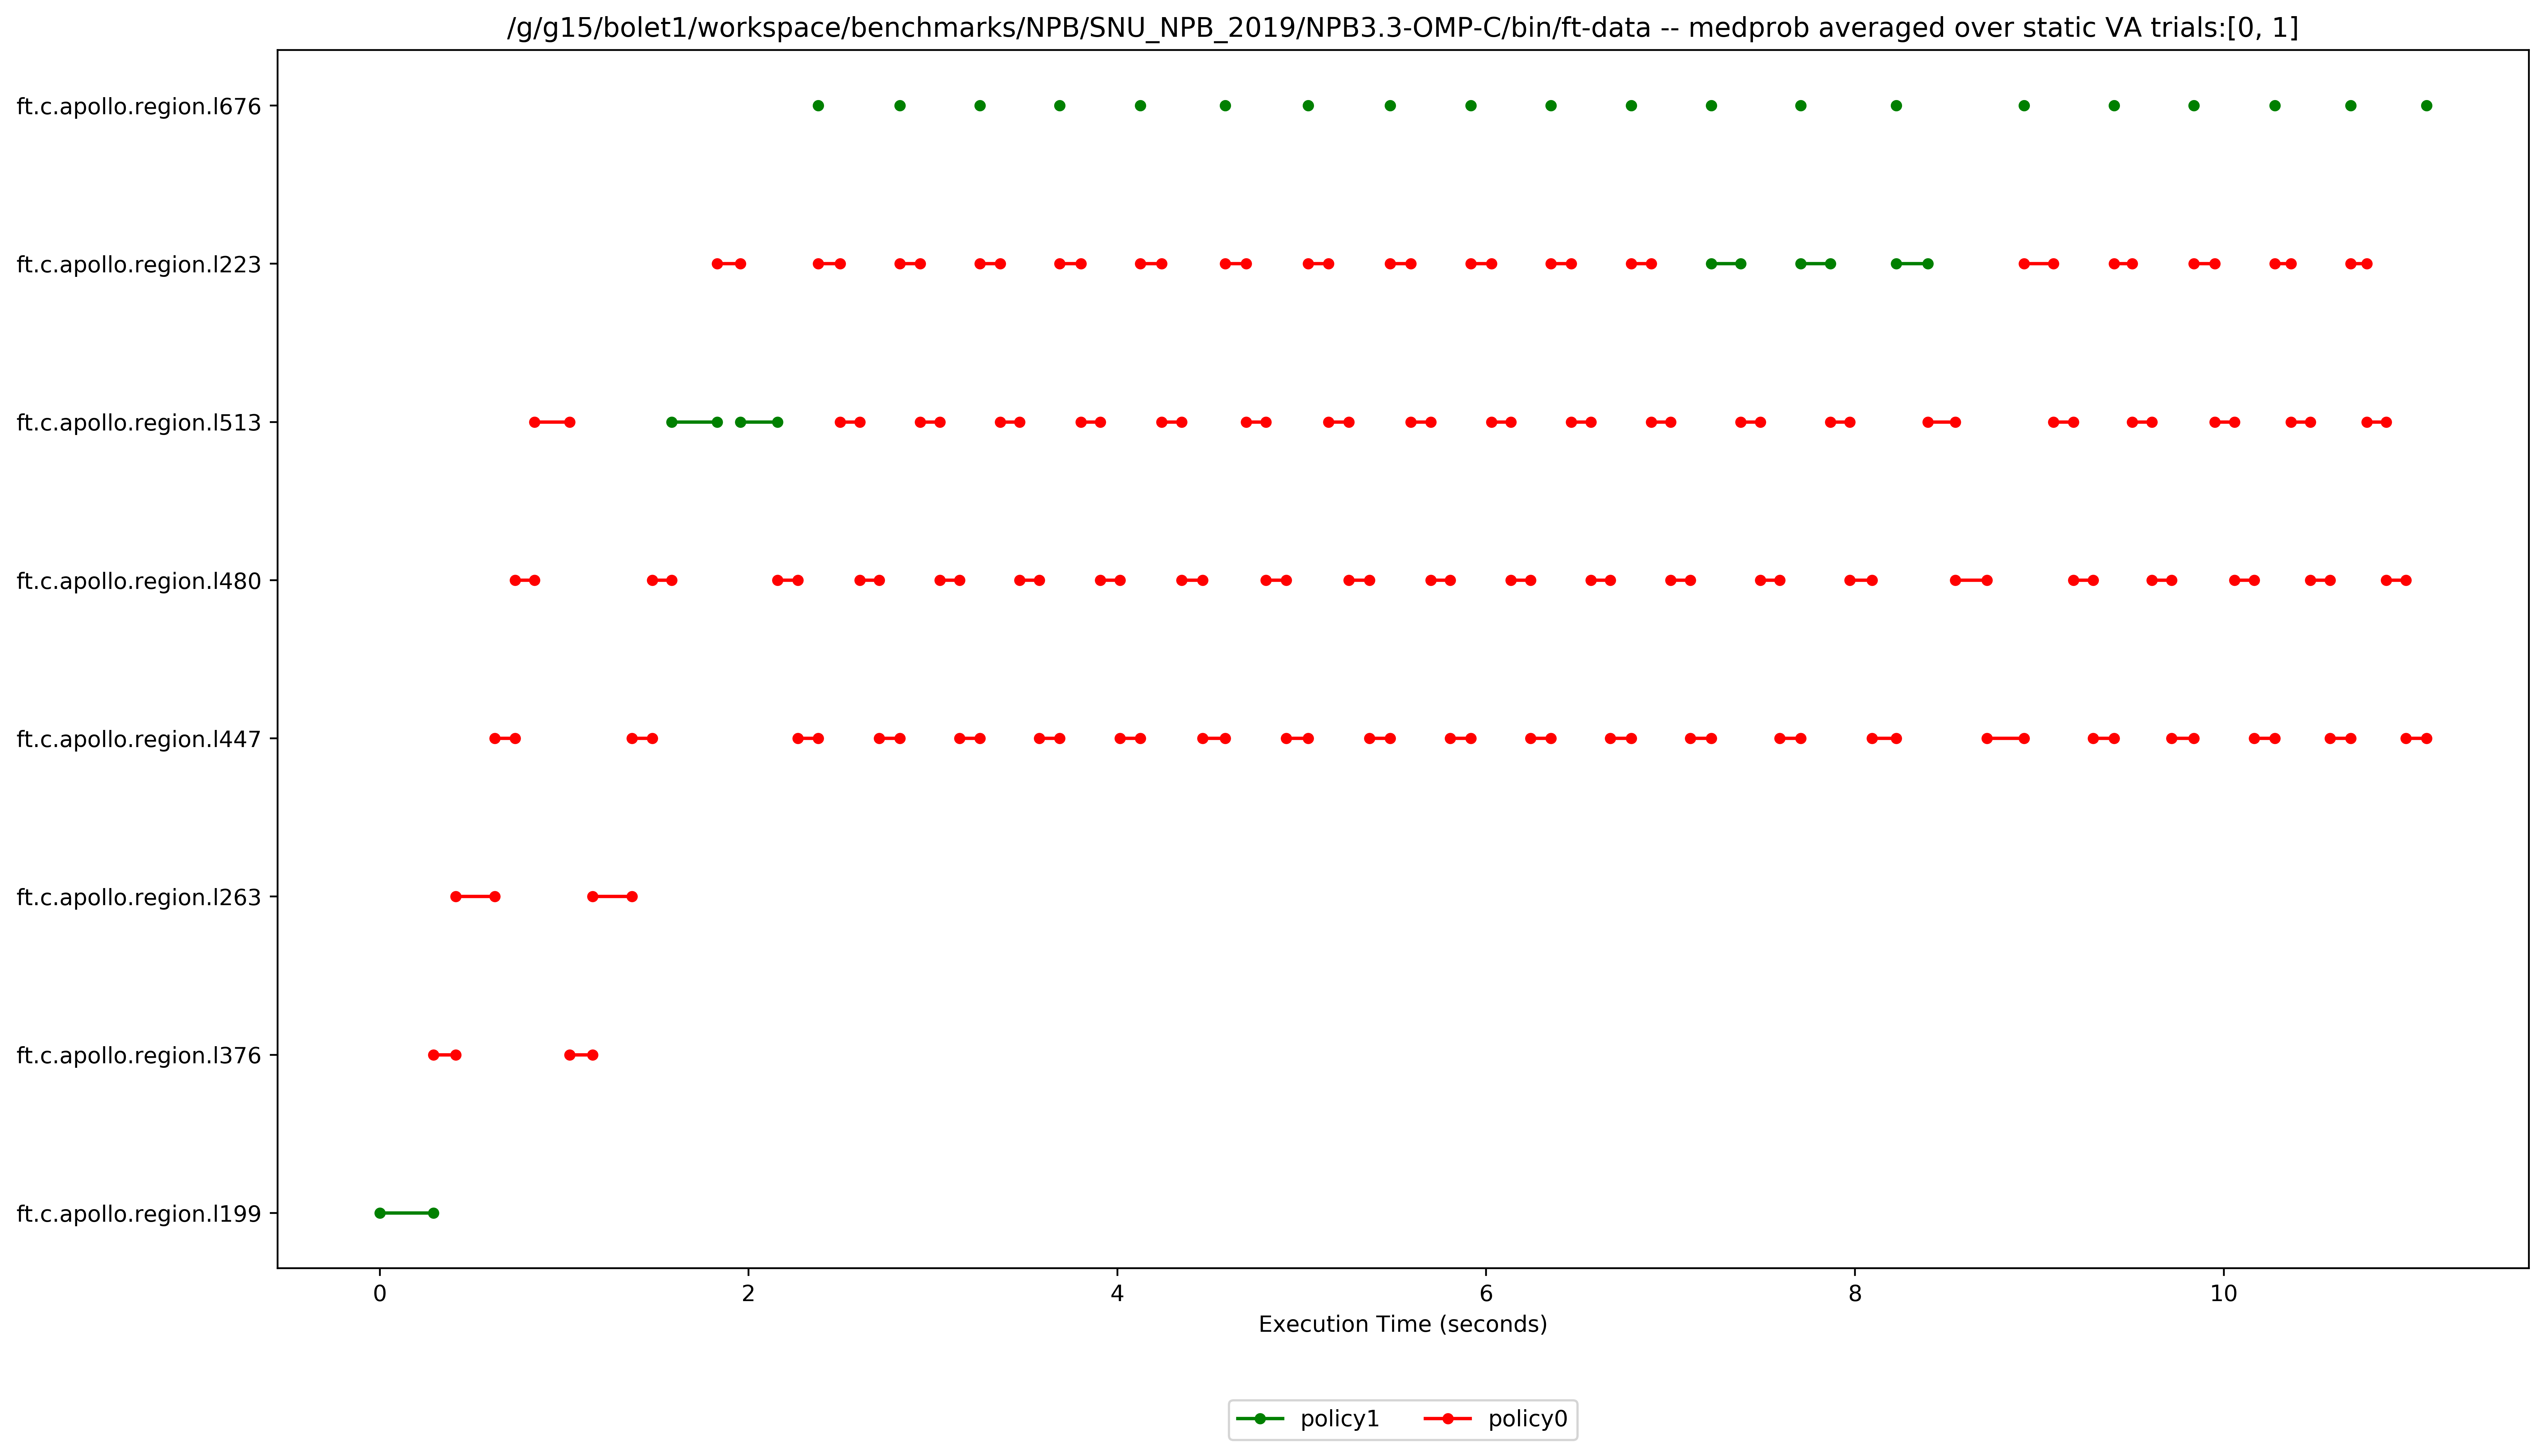

CPU times: user 5.66 s, sys: 245 ms, total: 5.91 s
Wall time: 5.89 s


In [9]:
%%time
plotOptimalPolicy(df, policiesToPlot=[0,1,2])

current index:  0 ( 0.9009009009009009 )
dict_keys(['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676'])


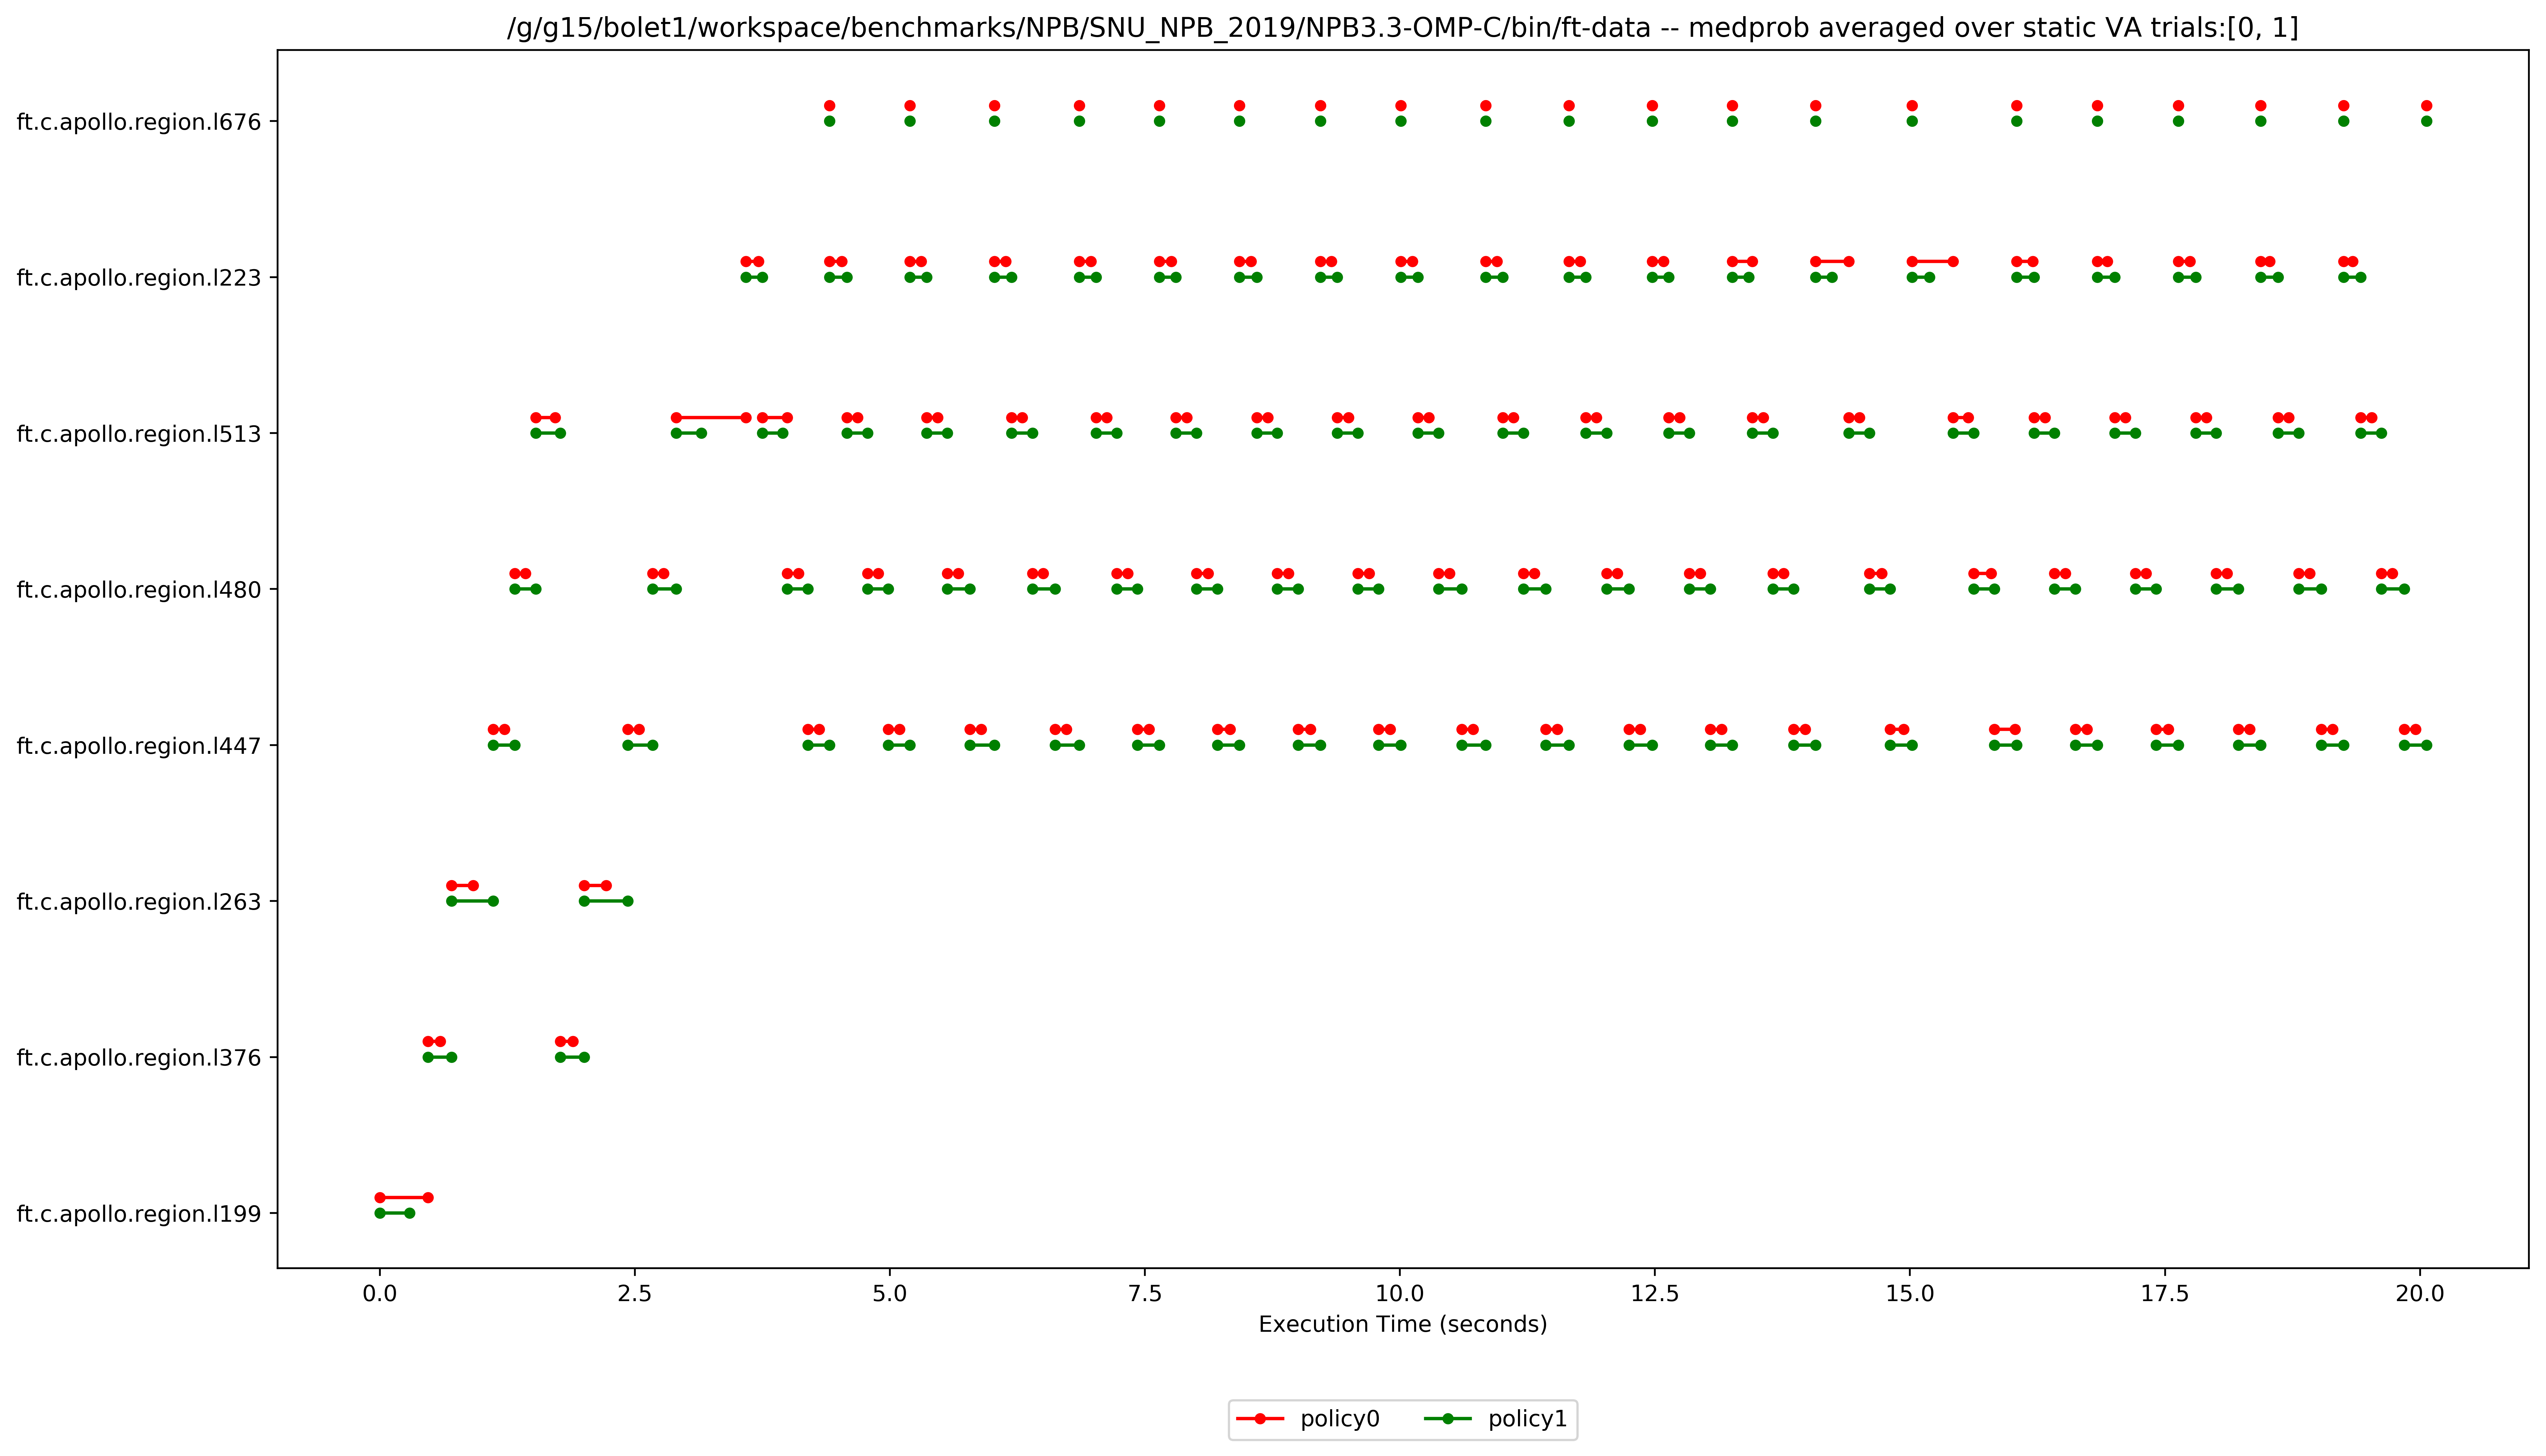

current index:  0 ( 0.9009009009009009 )
dict_keys(['ft.c.apollo.region.l199', 'ft.c.apollo.region.l376', 'ft.c.apollo.region.l263', 'ft.c.apollo.region.l447', 'ft.c.apollo.region.l480', 'ft.c.apollo.region.l513', 'ft.c.apollo.region.l223', 'ft.c.apollo.region.l676'])


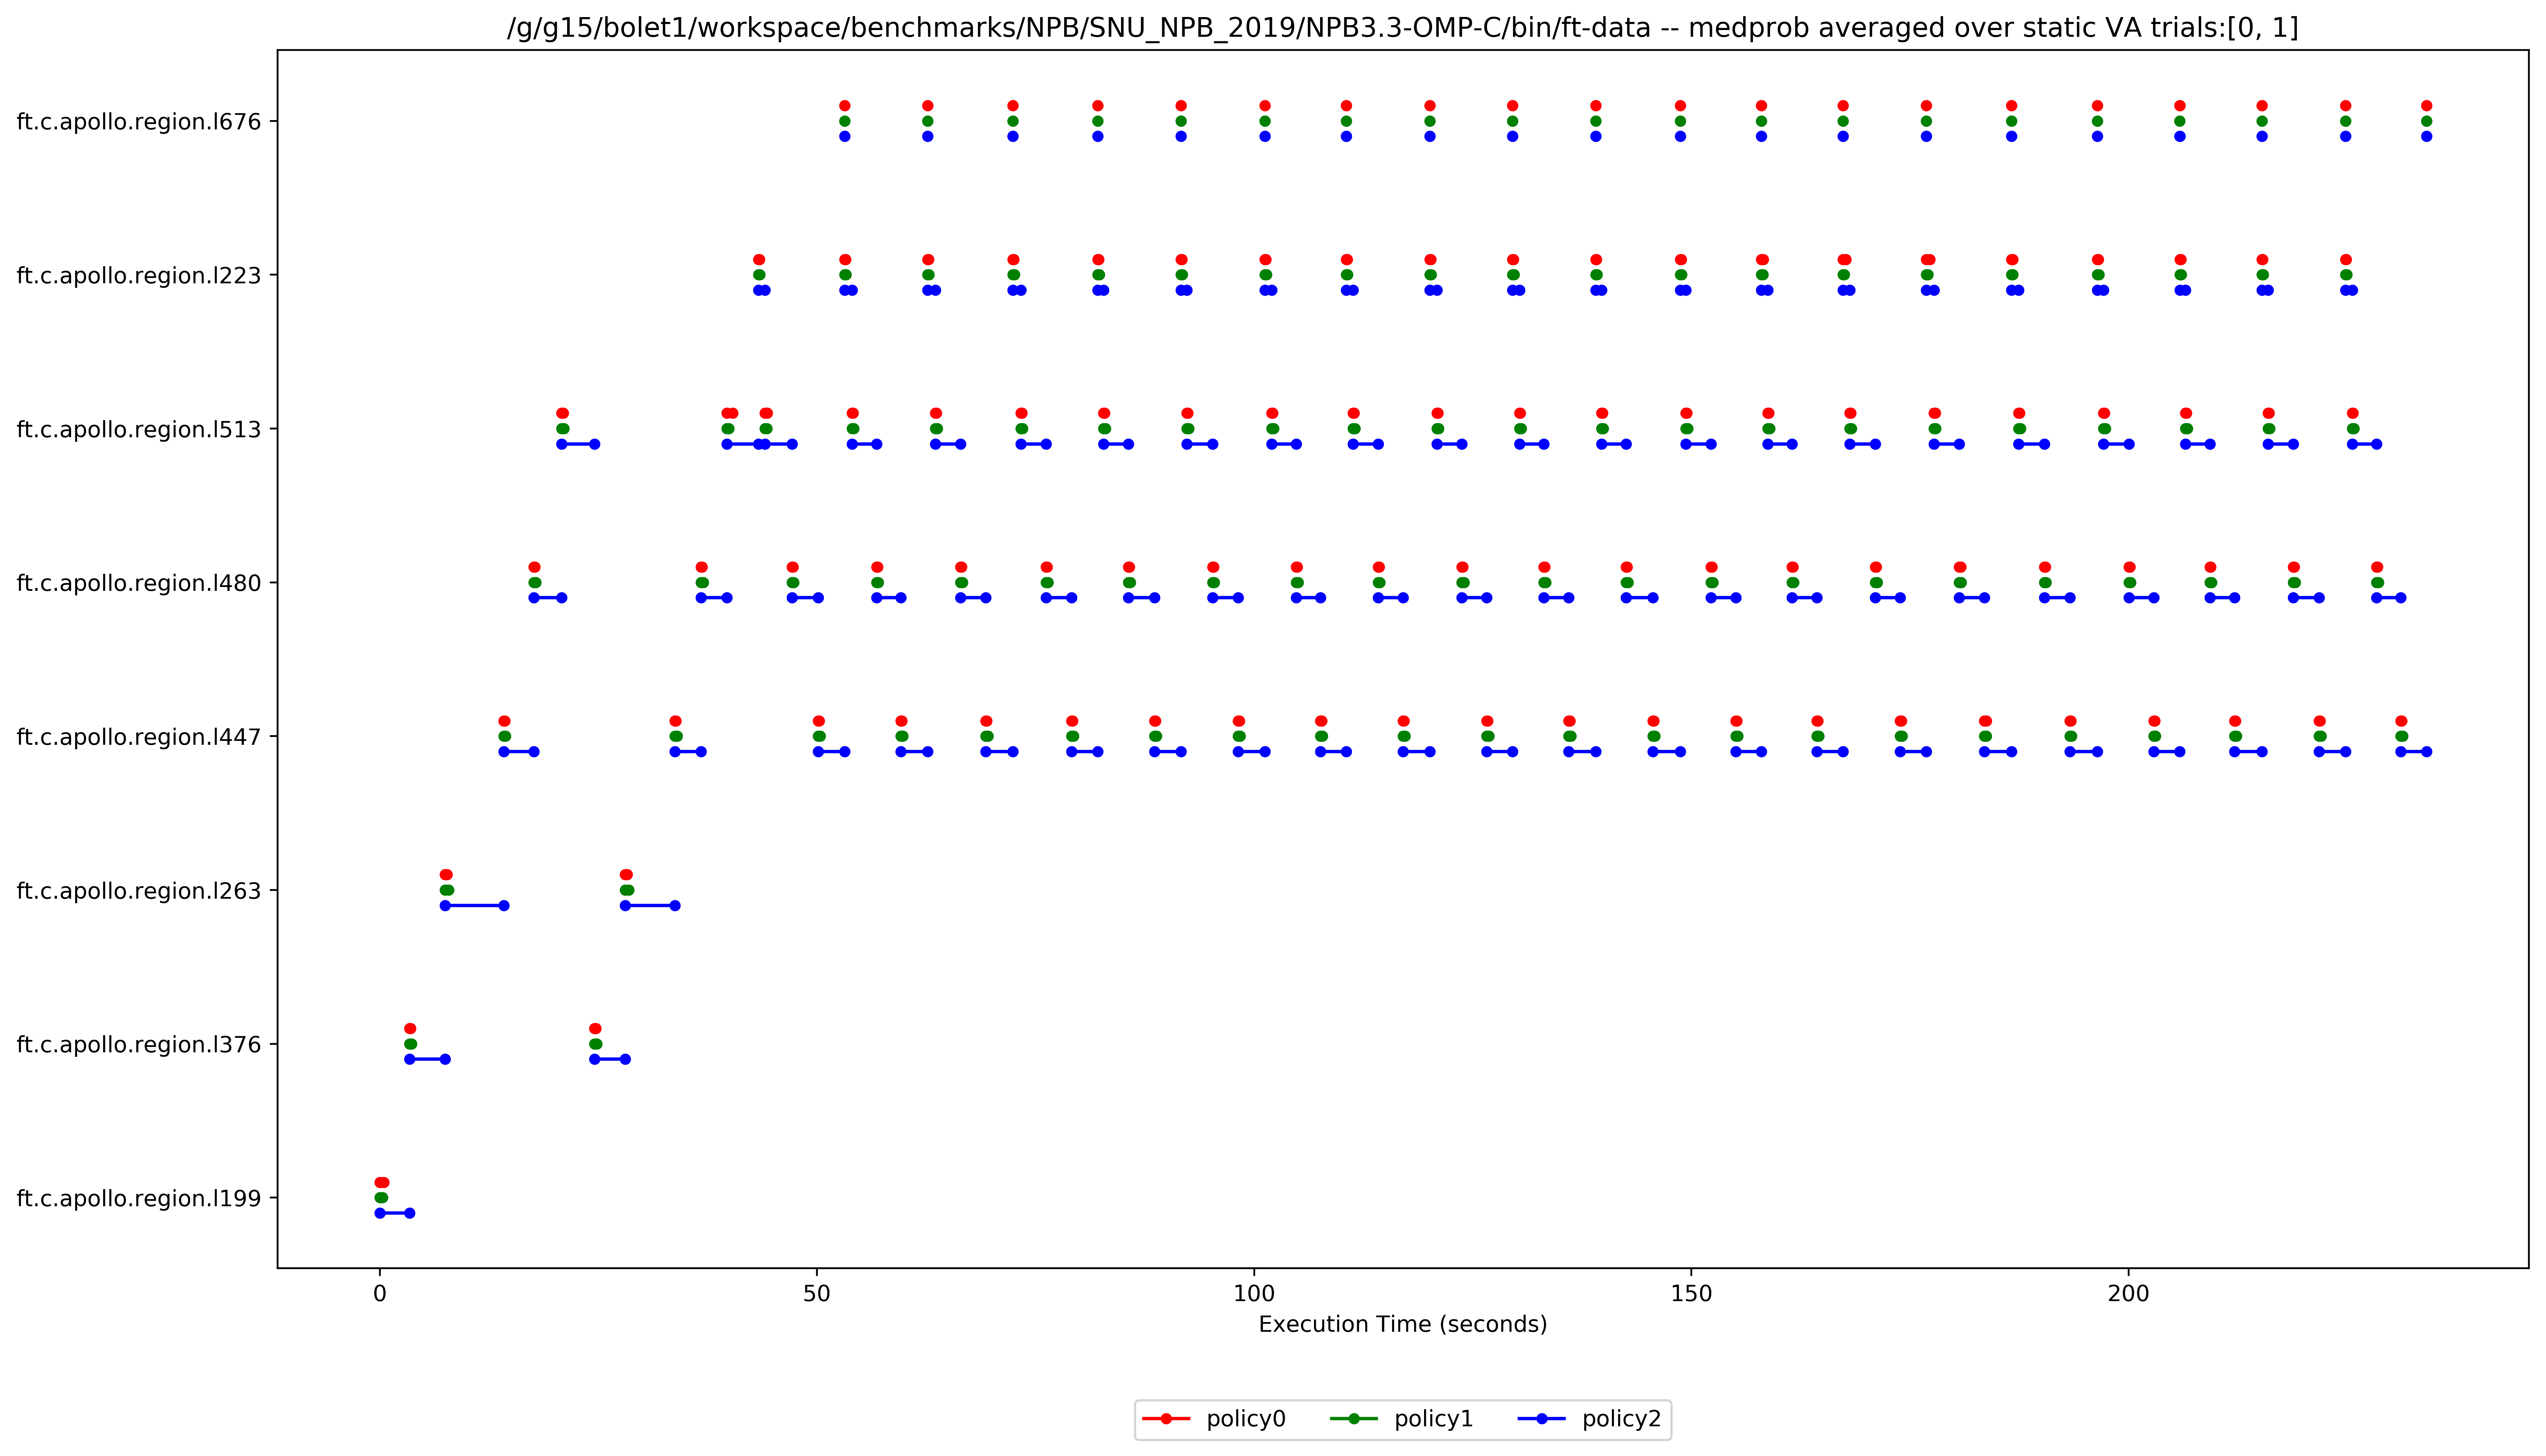

CPU times: user 13.2 s, sys: 505 ms, total: 13.7 s
Wall time: 13.7 s


In [8]:
%%time
plotAllPolicies(df, policiesToPlot=[0,1])
plotAllPolicies(df, policiesToPlot=[0,1,2])